In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import os.path

import scipy,scipy.spatial
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

from  data_utilities import *
# from definitions import *
# from run_train_eval_net import run_train_eval_net,run_eval_net

In [2]:
import os
GPU = "0"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=GPU

In [3]:
dataset_name = 'ManyRx'
dataset_path='../../orbit_rf_dataset/data/compact_pkl_datasets/'

compact_dataset = load_compact_pkl_dataset(dataset_path,dataset_name)

tx_list = compact_dataset['tx_list']
rx_list = compact_dataset['rx_list']

equalized = 1

capture_date_list = compact_dataset['capture_date_list']
capture_date = capture_date_list[0]
n_tx = len(tx_list)
n_rx = len(rx_list)
print(n_tx,n_rx)

10 32


In [4]:
np.random.seed(0)
n_real = 5
rx_list_real = []
for i in range(n_real):
    np.random.shuffle(rx_list)
    rx_list_real.append(np.copy(rx_list).tolist())
print(rx_list_real)

[['19-20', '24-13', '19-2', '1-20', '20-20', '20-1', '7-7', '3-19', '23-6', '2-19', '24-5', '14-7', '23-1', '19-1', '8-7', '24-6', '24-16', '1-19', '8-8', '18-19', '13-7', '23-3', '8-14', '23-5', '19-19', '18-2', '7-14', '13-14', '1-1', '23-7', '20-19', '2-1'], ['1-1', '23-1', '24-6', '8-8', '1-19', '23-3', '23-5', '7-14', '19-19', '13-14', '23-6', '7-7', '19-1', '20-1', '20-20', '24-16', '8-14', '19-2', '14-7', '1-20', '13-7', '24-5', '18-2', '2-19', '24-13', '19-20', '3-19', '8-7', '20-19', '2-1', '23-7', '18-19'], ['24-5', '23-7', '18-19', '23-3', '24-6', '8-14', '2-1', '13-7', '19-19', '19-2', '18-2', '1-20', '20-1', '24-16', '3-19', '1-19', '24-13', '23-6', '19-1', '8-7', '20-19', '1-1', '14-7', '20-20', '7-7', '2-19', '23-5', '8-8', '19-20', '13-14', '7-14', '23-1'], ['1-20', '1-19', '20-19', '23-7', '2-1', '20-1', '19-19', '14-7', '23-1', '3-19', '8-8', '7-7', '13-7', '20-20', '24-16', '18-2', '8-7', '23-5', '7-14', '18-19', '24-6', '19-1', '13-14', '2-19', '19-20', '24-5', '23-

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
 

/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/samer/miniconda3/envs/mod_framework/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/samer/miniconda3/en

In [6]:
 def create_net():


    inputs = Input(shape=(256,2))
    x = Reshape((256,2,1))(inputs)
    x = Conv2D(8,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,2))(x)
    x = Conv2D(32,(3,1),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,1),activation='relu',padding = 'same')(x)
    #x = resnet(x,64,(3,2),'6')
    #x = MaxPool2D((2,2))(x)
    x = Flatten()(x)



    x = Dense(100, activation='relu', kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    # x = Dropout(0.3)(x)
    x = Dense(80, activation='relu',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.5)(x)
    x = Dense(n_tx, activation='softmax',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    ops = x

    classifier = Model(inputs,ops)
    classifier.compile(loss='categorical_crossentropy',metrics=['categorical_accuracy'],optimizer=keras.optimizers.Adam(0.0005))
    
    return classifier

classifier = create_net()
classifier.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 2)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 2, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 2, 8)         56        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 2, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 2, 16)        784       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 2, 16)         0         
_________

In [7]:
def evaluate_test(classifier):
    pred = classifier.predict(sig_dfTest)
    acc = np.mean(np.argmax(pred,1)==txidNum_dfTest)

    test_indx = ()
    for indx in range(len(tx_list)):
        cls_indx = np.where(txidNum_dfTest == indx)
        test_indx = test_indx + (cls_indx[0][:n_test_samples],)
    test_indx = np.concatenate(test_indx) 
    acc_bal = np.mean(np.argmax(pred[test_indx,:],1)==txidNum_dfTest[test_indx])
    return acc,acc_bal

In [8]:
n_test_rx = 5;

In [9]:

list(range( 0,len(rx_list_real[0])-n_test_rx+1,5)) 

[0, 5, 10, 15, 20, 25]

In [10]:
TRAIN = True
continue_training = True
nreal = 5

real_list = list(range(nreal))
nrx_list =  list(range( 0,len(rx_list_real[0])-n_test_rx+1,5)) 

patience = 5
n_epochs = 100

smTest_results = []
dfTest_results = []
dfTestBal_results = []

for real in real_list:
    rx_list = rx_list_real[real]
    rx_test_list = rx_list[-n_test_rx:]
    test_dataset =  merge_compact_dataset(compact_dataset,capture_date,tx_list,rx_test_list,equalized=equalized)
    test_augset_dfRx,_,_ = prepare_dataset(test_dataset,tx_list,val_frac=0.0, test_frac=0.0)

    [sig_dfTest,txidNum_dfTest,txid_dfTest,cls_weights] = test_augset_dfRx

    cnt=np.histogram(txidNum_dfTest,bins=np.arange(len(tx_list)+1)-0.5)
    n_test_samples = int(np.min(cnt[0]))

    smTest_results_real = []
    dfTest_results_real = []
    dfTestBal_results_real = []
    for nrx in nrx_list:
        print("");print("")
        print("nrx: {} - real: {} ".format(nrx,real))
        fname_w = 'weights/d011_{:02d}_{:02d}.hd5'.format(nrx,real)
        rx_train_list= rx_list[:nrx+1]

        dataset =  merge_compact_dataset(compact_dataset,capture_date,tx_list,rx_train_list,equalized=equalized)

        train_augset,val_augset,test_augset_smRx =  prepare_dataset(dataset,tx_list,
                                                            val_frac=0.1, test_frac=0.1)
        [sig_train,txidNum_train,txid_train,cls_weights] = train_augset
        [sig_valid,txidNum_valid,txid_valid,_] = val_augset
        [sig_smTest,txidNum_smTest,txid_smTest,cls_weights] = test_augset_smRx
        
        if continue_training:
            skip = os.path.isfile(fname_w) or os.path.isfile(fname_w+'.index')
        else:
            skip = False
        classifier = create_net()
        if TRAIN and not skip:
            filepath = 't_weights_'+GPU
            c=[ keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True),
              keras.callbacks.EarlyStopping(monitor='val_loss',  patience=patience)]
            history = classifier.fit(sig_train,txid_train,class_weight=cls_weights,
                                     validation_data=(sig_valid , txid_valid),callbacks=c, epochs=n_epochs)
            classifier.load_weights(filepath)
            classifier.save_weights(fname_w)
        else:
            classifier.load_weights(fname_w).expect_partial()

        smTest_r = classifier.evaluate(sig_smTest,txid_smTest,verbose=0)[1]
    #     dfTest_r = classifier.evaluate(sig_dfTest,txid_dfTest)[1]
        dfTest_r,dfTestBal_r = evaluate_test(classifier)

        print(smTest_r,dfTest_r)
        smTest_results_real.append(smTest_r)
        dfTest_results_real.append(dfTest_r)
        dfTestBal_results_real.append(dfTestBal_r)
        K.clear_session()
    smTest_results.append(smTest_results_real)
    dfTest_results.append(dfTest_results_real)
    dfTestBal_results.append(dfTestBal_results_real)    
    
    
    


/home/samer/Documents/txid_framework/dataset_scripts/working/data_utilities.py:119: RuntimeWarning: invalid value encountered in true_divide
  cls_weights = np.max(stat,axis=0)/stat




nrx: 0 - real: 0 
0.93 0.3165


nrx: 5 - real: 0 
Train on 9440 samples, validate on 1180 samples
Epoch 1/100
9376/9440 [============================>.] - ETA: 0s - loss: 1.8050 - categorical_accuracy: 0.3344
Epoch 00001: val_loss improved from inf to 1.14972, saving model to t_weights_0
9440/9440 [==============================] - 2s 261us/sample - loss: 1.8019 - categorical_accuracy: 0.3357 - val_loss: 1.1497 - val_categorical_accuracy: 0.6212
Epoch 2/100
9216/9440 [============================>.] - ETA: 0s - loss: 1.0347 - categorical_accuracy: 0.6133
Epoch 00002: val_loss improved from 1.14972 to 0.76160, saving model to t_weights_0
9440/9440 [==============================] - 2s 215us/sample - loss: 1.0334 - categorical_accuracy: 0.6140 - val_loss: 0.7616 - val_categorical_accuracy: 0.7449
Epoch 3/100
9408/9440 [============================>.] - ETA: 0s - loss: 0.7896 - categorical_accuracy: 0.7061
Epoch 00003: val_loss improved from 0.76160 to 0.57286, saving model to t_weights

/home/samer/Documents/txid_framework/dataset_scripts/working/data_utilities.py:119: RuntimeWarning: invalid value encountered in true_divide
  cls_weights = np.max(stat,axis=0)/stat


Train on 1600 samples, validate on 200 samples
Epoch 1/100
1376/1600 [========================>.....] - ETA: 0s - loss: 2.2664 - categorical_accuracy: 0.1890
Epoch 00001: val_loss improved from inf to 2.06093, saving model to t_weights_0
1600/1600 [==============================] - 1s 514us/sample - loss: 2.2499 - categorical_accuracy: 0.2050 - val_loss: 2.0609 - val_categorical_accuracy: 0.4850
Epoch 2/100
1344/1600 [========================>.....] - ETA: 0s - loss: 1.7373 - categorical_accuracy: 0.3914
Epoch 00002: val_loss improved from 2.06093 to 1.06915, saving model to t_weights_0
1600/1600 [==============================] - 0s 264us/sample - loss: 1.6636 - categorical_accuracy: 0.4112 - val_loss: 1.0691 - val_categorical_accuracy: 0.7700
Epoch 3/100
1568/1600 [============================>.] - ETA: 0s - loss: 1.0713 - categorical_accuracy: 0.5989
Epoch 00003: val_loss improved from 1.06915 to 0.73259, saving model to t_weights_0
1600/1600 [==============================] - 0s 26

/home/samer/Documents/txid_framework/dataset_scripts/working/data_utilities.py:119: RuntimeWarning: invalid value encountered in true_divide
  cls_weights = np.max(stat,axis=0)/stat


Train on 1600 samples, validate on 200 samples
Epoch 1/100
1504/1600 [===========================>..] - ETA: 0s - loss: 2.2804 - categorical_accuracy: 0.1875
Epoch 00001: val_loss improved from inf to 2.14947, saving model to t_weights_0
1600/1600 [==============================] - 1s 485us/sample - loss: 2.2741 - categorical_accuracy: 0.1988 - val_loss: 2.1495 - val_categorical_accuracy: 0.4900
Epoch 2/100
1376/1600 [========================>.....] - ETA: 0s - loss: 1.8347 - categorical_accuracy: 0.4906
Epoch 00002: val_loss improved from 2.14947 to 1.11775, saving model to t_weights_0
1600/1600 [==============================] - 0s 252us/sample - loss: 1.7612 - categorical_accuracy: 0.5056 - val_loss: 1.1177 - val_categorical_accuracy: 0.7200
Epoch 3/100
1344/1600 [========================>.....] - ETA: 0s - loss: 0.9990 - categorical_accuracy: 0.6577
Epoch 00003: val_loss improved from 1.11775 to 0.49500, saving model to t_weights_0
1600/1600 [==============================] - 0s 26

/home/samer/Documents/txid_framework/dataset_scripts/working/data_utilities.py:119: RuntimeWarning: invalid value encountered in true_divide
  cls_weights = np.max(stat,axis=0)/stat
/home/samer/Documents/txid_framework/dataset_scripts/working/data_utilities.py:119: RuntimeWarning: divide by zero encountered in true_divide
  cls_weights = np.max(stat,axis=0)/stat


Train on 1440 samples, validate on 180 samples
Epoch 1/100
1376/1440 [===========================>..] - ETA: 0s - loss: 2.2088 - categorical_accuracy: 0.2493
Epoch 00001: val_loss improved from inf to 1.96212, saving model to t_weights_0
1440/1440 [==============================] - 1s 536us/sample - loss: 2.1999 - categorical_accuracy: 0.2535 - val_loss: 1.9621 - val_categorical_accuracy: 0.5333
Epoch 2/100
1376/1440 [===========================>..] - ETA: 0s - loss: 1.5695 - categorical_accuracy: 0.4891
Epoch 00002: val_loss improved from 1.96212 to 0.97583, saving model to t_weights_0
1440/1440 [==============================] - 0s 272us/sample - loss: 1.5510 - categorical_accuracy: 0.4917 - val_loss: 0.9758 - val_categorical_accuracy: 0.5444
Epoch 3/100
1312/1440 [==========================>...] - ETA: 0s - loss: 0.9540 - categorical_accuracy: 0.6280
Epoch 00003: val_loss improved from 0.97583 to 0.65258, saving model to t_weights_0
1440/1440 [==============================] - 0s 27

/home/samer/Documents/txid_framework/dataset_scripts/working/data_utilities.py:119: RuntimeWarning: invalid value encountered in true_divide
  cls_weights = np.max(stat,axis=0)/stat


Train on 1600 samples, validate on 200 samples
Epoch 1/100
1568/1600 [============================>.] - ETA: 0s - loss: 2.2708 - categorical_accuracy: 0.1990
Epoch 00001: val_loss improved from inf to 2.13156, saving model to t_weights_0
1600/1600 [==============================] - 1s 490us/sample - loss: 2.2681 - categorical_accuracy: 0.2013 - val_loss: 2.1316 - val_categorical_accuracy: 0.2000
Epoch 2/100
1344/1600 [========================>.....] - ETA: 0s - loss: 1.8939 - categorical_accuracy: 0.3490
Epoch 00002: val_loss improved from 2.13156 to 1.30188, saving model to t_weights_0
1600/1600 [==============================] - 0s 268us/sample - loss: 1.8358 - categorical_accuracy: 0.3694 - val_loss: 1.3019 - val_categorical_accuracy: 0.5300
Epoch 3/100
1440/1600 [==========================>...] - ETA: 0s - loss: 1.1994 - categorical_accuracy: 0.5681
Epoch 00003: val_loss improved from 1.30188 to 0.67218, saving model to t_weights_0
1600/1600 [==============================] - 0s 27

In [11]:
nrx_list

[0, 5, 10, 15, 20, 25]

[0.32337888499973955, 0.5424953835515883, 0.672989333323014, 0.7467292965345177, 0.7870676739712519, 0.7908500635310862]


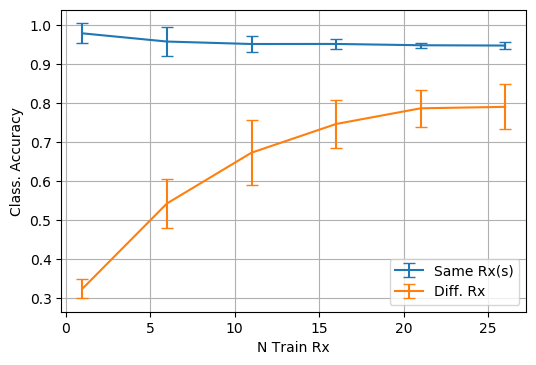

In [18]:
matplotlib.rcParams['figure.dpi'] = 100
plt.errorbar(np.array(nrx_list)+1,np.mean(smTest_results,0),np.std(smTest_results,0),capsize=4)
plt.errorbar(np.array(nrx_list)+1,np.mean(dfTest_results,0),np.std(dfTest_results,0),capsize=4)
plt.legend(['Same Rx(s)','Diff. Rx'])
plt.xlabel('N Train Rx')
plt.ylabel('Class. Accuracy')
#plt.xticks(range(0,len(nrx_list),2))
plt.grid()
print(np.mean(dfTest_results,0).tolist())

In [13]:
print(tx_list)
print(nrx_list)
print(real_list)
print(smTest_results)
print(dfTest_results)
print(dfTestBal_results)

['1-10', '11-1', '14-10', '14-7', '17-11', '20-15', '20-19', '7-11', '7-14', '8-20']
[0, 5, 10, 15, 20, 25]
[0, 1, 2, 3, 4]
[[0.93, 0.8940678, 0.93426573, 0.9349855, 0.9390813, 0.9486974], [1.0, 0.9813333, 0.98435974, 0.97603416, 0.95185554, 0.9362086], [0.995, 0.9895105, 0.9354078, 0.9435563, 0.94364804, 0.94269794], [0.98888886, 0.98706895, 0.9722222, 0.95170176, 0.9557984, 0.9546449], [0.985, 0.9413764, 0.9355586, 0.9563277, 0.9554468, 0.9597194]]
[[0.3165, 0.5837, 0.767, 0.8163, 0.8418, 0.8252], [0.3539, 0.6334, 0.6731, 0.8027, 0.8417, 0.8553], [0.3097758405977584, 0.5153590701535907, 0.7284142797841427, 0.7468866749688667, 0.7787463677874636, 0.8270029057700291], [0.28977980889073535, 0.44869131699210635, 0.5234732031574574, 0.6456169505608641, 0.7226838388034899, 0.7449106771915247], [0.3469387755102041, 0.5313265306122449, 0.6729591836734694, 0.7221428571428572, 0.7504081632653061, 0.7018367346938775]]
[[0.3165, 0.5837, 0.767, 0.8163, 0.8418, 0.8252], [0.3539, 0.6334, 0.6731, 0.

In [14]:
print(rx_list_real)

[['19-20', '24-13', '19-2', '1-20', '20-20', '20-1', '7-7', '3-19', '23-6', '2-19', '24-5', '14-7', '23-1', '19-1', '8-7', '24-6', '24-16', '1-19', '8-8', '18-19', '13-7', '23-3', '8-14', '23-5', '19-19', '18-2', '7-14', '13-14', '1-1', '23-7', '20-19', '2-1'], ['1-1', '23-1', '24-6', '8-8', '1-19', '23-3', '23-5', '7-14', '19-19', '13-14', '23-6', '7-7', '19-1', '20-1', '20-20', '24-16', '8-14', '19-2', '14-7', '1-20', '13-7', '24-5', '18-2', '2-19', '24-13', '19-20', '3-19', '8-7', '20-19', '2-1', '23-7', '18-19'], ['24-5', '23-7', '18-19', '23-3', '24-6', '8-14', '2-1', '13-7', '19-19', '19-2', '18-2', '1-20', '20-1', '24-16', '3-19', '1-19', '24-13', '23-6', '19-1', '8-7', '20-19', '1-1', '14-7', '20-20', '7-7', '2-19', '23-5', '8-8', '19-20', '13-14', '7-14', '23-1'], ['1-20', '1-19', '20-19', '23-7', '2-1', '20-1', '19-19', '14-7', '23-1', '3-19', '8-8', '7-7', '13-7', '20-20', '24-16', '18-2', '8-7', '23-5', '7-14', '18-19', '24-6', '19-1', '13-14', '2-19', '19-20', '24-5', '23-